<a href="https://colab.research.google.com/github/PrajyotKale/UPI-Fraud-Detector/blob/master/Final_PD3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Preprocessing data...
Training XGBoost model...
Training PyTorch Transformer model...
Epoch 1/1000, Train Loss: 0.3468, Val Loss: 0.2939
Epoch 2/1000, Train Loss: 0.3011, Val Loss: 0.2925
Epoch 3/1000, Train Loss: 0.2991, Val Loss: 0.2909
Epoch 4/1000, Train Loss: 0.2965, Val Loss: 0.2902
Epoch 5/1000, Train Loss: 0.2960, Val Loss: 0.2891
Epoch 6/1000, Train Loss: 0.2949, Val Loss: 0.2890
Epoch 7/1000, Train Loss: 0.2938, Val Loss: 0.2892
Epoch 8/1000, Train Loss: 0.2948, Val Loss: 0.2889
Epoch 9/1000, Train Loss: 0.2944, Val Loss: 0.2899
Epoch 10/1000, Train Loss: 0.2934, Val Loss: 0.2894
Epoch 11/1000, Train Loss: 0.2932, Val Loss: 0.2897
Epoch 12/1000, Train Loss: 0.2930, Val Loss: 0.2886
Epoch 13/1000, Train Loss: 0.2931, Val Loss: 0.2883
Epoch 14/1000, Train Loss: 0.2929, Val Loss: 0.2883
Epoch 15/1000, Train Loss: 0.2912, Val Loss: 0.2883
Epoch 16/1000, Train Loss: 0.2927, Val Loss: 0.2879
Epoch 17/1000, Train Loss: 0.2921, Val Loss: 0.2878
Epoch 18/1000, Train

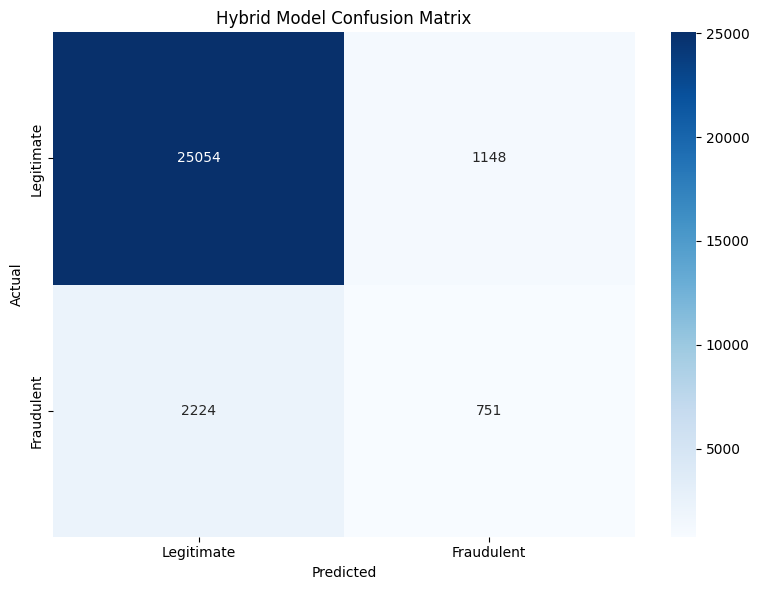

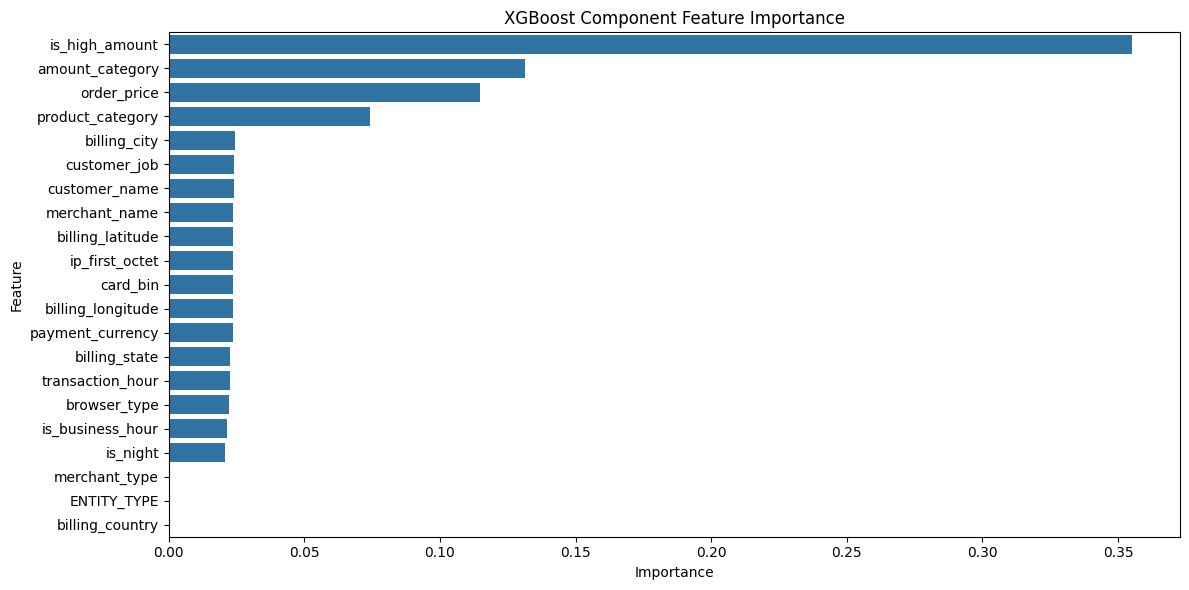


Sample Transaction Prediction:
Amount: $899.99, Hour: 21
Prediction: Legitimate (Confidence: 34.68%)
Risk Level: Low
Model Scores - XGBoost: 49.28%, Transformer: 45.52%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Modified Fraud Detection Project with Hybrid Gradient Boosting and PyTorch Transformer Model
# For transaction data with fields like EVENT_LABEL, EVENT_TIMESTAMP, ENTITY_ID, etc.

# Step 1: Install Required Libraries
# !pip install pandas numpy matplotlib seaborn xgboost scikit-learn torch optuna

# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, auc
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 3: Load existing data
# Uncomment the line below and specify your file path
# df = pd.read_csv('your_transaction_data.csv')
# print(f"Dataset loaded with {len(df)} records")

# For demonstration, we'll assume the data is loaded in DataFrame 'df'
# with columns as specified in the sample data:
# EVENT_LABEL, EVENT_TIMESTAMP, LABEL_TIMESTAMP, EVENT_ID, ENTITY_TYPE, ENTITY_ID,
# card_bin, customer_name, billing_street, billing_city, billing_state, billing_zip,
# billing_latitude, billing_longitude, billing_country, customer_job, ip_address,
# customer_email, billing_phone, user_agent, product_category, order_price,
# payment_currency, merchant

# Step 4: Data Preprocessing
def preprocess_data(df):
    """
    Preprocess the transaction data for fraud detection

    Parameters:
    df (DataFrame): Raw transaction data

    Returns:
    dict: Processed data, features, and preprocessing objects
    """
    print("Preprocessing data...")

    # Create copy to avoid modifying original
    data = df.copy()

    # 4.1 Extract hour from timestamp
    data['transaction_hour'] = data['EVENT_TIMESTAMP'].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ").hour if isinstance(x, str) else 0
    )

    # 4.2 Extract merchant type (fraud or legit)
    data['merchant_type'] = data['merchant'].apply(
        lambda x: 1 if isinstance(x, str) and x.lower().startswith('fraud') else 0
    )

    # 4.3 Extract merchant name
    data['merchant_name'] = data['merchant'].apply(
        lambda x: x.split('_', 1)[1] if isinstance(x, str) and '_' in x else x
    )

    # 4.4 Fix target variable if needed
    if 'EVENT_LABEL' in data.columns:
        data['isFraud'] = data['EVENT_LABEL']

    # 4.5 Encode categorical variables
    categorical_cols = [
        'ENTITY_TYPE', 'card_bin', 'customer_name', 'billing_city',
        'billing_state', 'billing_country', 'customer_job',
        'product_category', 'payment_currency', 'merchant_name'
    ]

    # Filter to include only columns that exist
    categorical_cols = [col for col in categorical_cols if col in data.columns]

    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        # Handle potential NaN values
        data[col] = data[col].fillna('unknown')
        data[col] = label_encoders[col].fit_transform(data[col])

    # 4.6 Feature Engineering
    # Create time-based features
    data['is_night'] = data['transaction_hour'].apply(lambda x: 1 if x >= 20 or x <= 5 else 0)
    data['is_business_hour'] = data['transaction_hour'].apply(lambda x: 1 if 9 <= x <= 18 else 0)

    # Create amount-based features
    data['amount_category'] = pd.qcut(data['order_price'].fillna(0), 5, labels=False, duplicates='drop')
    data['is_high_amount'] = data['order_price'].apply(lambda x: 1 if x >= 800 else 0)

    # Extract IP information (first octet) if available
    if 'ip_address' in data.columns:
        data['ip_first_octet'] = data['ip_address'].apply(
            lambda x: int(str(x).split('.')[0]) if isinstance(x, str) and '.' in str(x) else 0
        )
    else:
        data['ip_first_octet'] = 0

    # Browser type from user agent if available
    if 'user_agent' in data.columns:
        def extract_browser(user_agent):
            if not isinstance(user_agent, str):
                return 0
            user_agent = user_agent.lower()
            if 'chrome' in user_agent:
                return 0
            elif 'firefox' in user_agent:
                return 1
            elif 'safari' in user_agent:
                return 2
            elif 'opera' in user_agent:
                return 3
            elif 'edge' in user_agent:
                return 4
            elif 'msie' in user_agent or 'trident' in user_agent:
                return 5
            else:
                return 6

        data['browser_type'] = data['user_agent'].apply(extract_browser)
    else:
        data['browser_type'] = 0

    # Define features and target
    features = [
        'transaction_hour', 'merchant_type', 'is_night', 'is_business_hour',
        'amount_category', 'is_high_amount', 'ip_first_octet', 'browser_type',
        'order_price'
    ]

    # Add categorical features if available
    for col in categorical_cols:
        if col in data.columns:
            features.append(col)

    # Add geolocation if available
    if 'billing_latitude' in data.columns and 'billing_longitude' in data.columns:
        features.extend(['billing_latitude', 'billing_longitude'])

    # Make sure all feature columns exist in the data
    features = [col for col in features if col in data.columns]

    # Define numerical features for the transformer model
    numerical_features = ['order_price', 'transaction_hour']
    if 'billing_latitude' in data.columns and 'billing_longitude' in data.columns:
        numerical_features.extend(['billing_latitude', 'billing_longitude'])
    if 'ip_first_octet' in data.columns:
        numerical_features.append('ip_first_octet')

    # Scale numerical features for the transformer model
    scaler = StandardScaler()
    X_numerical = scaler.fit_transform(data[numerical_features])

    # Define X and y
    X = data[features]
    y = data['isFraud']

    return {
        'data': data,
        'X': X,
        'y': y,
        'X_numerical': X_numerical,
        'features': features,
        'numerical_features': numerical_features,
        'label_encoders': label_encoders,
        'scaler': scaler
    }

# PyTorch Dataset Class
class FraudDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Transformer Model Architecture
class TransformerFraudModel(nn.Module):
    def __init__(self, input_dim, num_heads=2, dropout_rate=0.2, hidden_dim=32):
        super(TransformerFraudModel, self).__init__()

        # Initial dense layer
        self.dense = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()

        # Transformer block
        self.multihead_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout_rate,
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(hidden_dim)

        # Output layers
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initial processing
        x = self.activation(self.dense(x))
        x = x.unsqueeze(1)  # Add sequence dimension [batch, 1, hidden_dim]

        # Self-attention
        attn_output, _ = self.multihead_attention(x, x, x)
        x = self.layer_norm(x + attn_output)

        # Average pooling (since we have only one sequence element)
        x = x.squeeze(1)

        # Output layer
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

# Training function for PyTorch model
def train_transformer_model(X_train_num, y_train, X_val_num, y_val, batch_size=256, num_epochs=1000, early_stopping_patience=5):
    """Train the transformer model with early stopping"""
    # Create datasets and dataloaders
    train_dataset = FraudDataset(X_train_num, y_train)
    val_dataset = FraudDataset(X_val_num, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    model = TransformerFraudModel(input_dim=X_train_num.shape[1]).to(device)

    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early stopping variables
    best_val_loss = float('inf')
    early_stopping_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * inputs.size(0)

        train_loss = total_train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                total_val_loss += loss.item() * inputs.size(0)

        val_loss = total_val_loss / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

# Create Hybrid Model Function
def create_hybrid_model(processed_data):
    """Create and train a hybrid model combining XGBoost and PyTorch Transformer"""
    X = processed_data['X']
    y = processed_data['y']
    y.fillna(0, inplace=True)  # Handle NaN values in the target
    X_numerical = processed_data['X_numerical']
    # Train-Test Split with Stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    # Prepare data for transformer model
    X_train_indices = X_train.index
    X_test_indices = X_test.index

    X_train_numerical = X_numerical[X_train_indices]
    X_test_numerical = X_numerical[X_test_indices]

    # Train XGBoost model
    print("Training XGBoost model...")
    xgb_model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)

    # Get XGBoost predictions for training data
    xgb_train_preds = xgb_model.predict_proba(X_train)[:, 1]
    xgb_test_preds = xgb_model.predict_proba(X_test)[:, 1]

    # Split training data to create validation set for transformer
    X_train_val, X_val, y_train_val, y_val = train_test_split(
        X_train_numerical, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    # Train Transformer model on numerical features
    print("Training PyTorch Transformer model...")
    transformer_model = train_transformer_model(X_train_val, y_train_val, X_val, y_val)

    # Get Transformer predictions
    transformer_model.eval()
    with torch.no_grad():
        train_tensor = torch.tensor(X_train_numerical, dtype=torch.float32).to(device)
        test_tensor = torch.tensor(X_test_numerical, dtype=torch.float32).to(device)

        transformer_train_preds = transformer_model(train_tensor).cpu().numpy().flatten()
        transformer_test_preds = transformer_model(test_tensor).cpu().numpy().flatten()

    # Create meta-features for meta-learner
    meta_train_features = np.column_stack([
        xgb_train_preds,
        transformer_train_preds,
        X_train['order_price'],
        X_train['transaction_hour'],
        X_train['is_night'] if 'is_night' in X_train.columns else np.zeros(len(X_train)),
        X_train['is_high_amount'] if 'is_high_amount' in X_train.columns else np.zeros(len(X_train))
    ])

    meta_test_features = np.column_stack([
        xgb_test_preds,
        transformer_test_preds,
        X_test['order_price'],
        X_test['transaction_hour'],
        X_test['is_night'] if 'is_night' in X_test.columns else np.zeros(len(X_test)),
        X_test['is_high_amount'] if 'is_high_amount' in X_test.columns else np.zeros(len(X_test))
    ])

    # Train meta-learner (final model)
    print("Training meta-learner...")
    meta_model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    meta_model.fit(meta_train_features, y_train)

    # Evaluate the model
    meta_preds = meta_model.predict(meta_test_features)
    meta_pred_proba = meta_model.predict_proba(meta_test_features)[:, 1]

    print("\n--- Hybrid Model Evaluation ---")
    accuracy = accuracy_score(y_test, meta_preds)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, meta_preds))

    # ROC-AUC score
    roc_auc = roc_auc_score(y_test, meta_pred_proba)
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # PR-AUC score
    precision, recall, _ = precision_recall_curve(y_test, meta_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC Score: {pr_auc:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, meta_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Fraudulent'],
                yticklabels=['Legitimate', 'Fraudulent'])
    plt.title('Hybrid Model Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Feature importance from XGBoost component
    plt.figure(figsize=(12, 6))
    xgb_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': xgb_model.feature_importances_
    })
    xgb_importance = xgb_importance.sort_values('Importance', ascending=False)
    sns.barplot(data=xgb_importance, x='Importance', y='Feature')
    plt.title('XGBoost Component Feature Importance')
    plt.tight_layout()
    plt.show()

    return {
        'xgb_model': xgb_model,
        'transformer_model': transformer_model,
        'meta_model': meta_model,
        'scaler': processed_data['scaler'],
        'label_encoders': processed_data['label_encoders'],
        'features': processed_data['features'],
        'numerical_features': processed_data['numerical_features'],
        'X_test': X_test,
        'y_test': y_test,
        'meta_test_features': meta_test_features
    }

# Enhanced Prediction Function
def predict_fraud_hybrid(transaction_data, hybrid_models):
    """
    Predict if a transaction is fraudulent using the hybrid model

    Parameters:
    transaction_data (dict): Transaction details with fields matching the training data
    hybrid_models (dict): Dictionary containing trained models and preprocessing objects

    Returns:
    dict: Prediction results with classification and confidence score
    """
    # Process input data
    processed_data = {}

    # Extract transaction hour from timestamp
    if 'EVENT_TIMESTAMP' in transaction_data:
        timestamp = transaction_data['EVENT_TIMESTAMP']
        dt = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%SZ")
        processed_data['transaction_hour'] = dt.hour
    else:
        processed_data['transaction_hour'] = 12  # Default if not provided

    # Extract merchant type and name
    if 'merchant' in transaction_data:
        merchant = transaction_data['merchant']
        processed_data['merchant_type'] = 1 if merchant.lower().startswith('fraud') else 0
        processed_data['merchant_name'] = merchant.split('_', 1)[1] if '_' in merchant else merchant
    else:
        processed_data['merchant_type'] = 0
        processed_data['merchant_name'] = 'Unknown'

    # Handle categorical features
    for col, encoder in hybrid_models['label_encoders'].items():
        if col in transaction_data:
            try:
                processed_data[col] = encoder.transform([transaction_data[col]])[0]
            except (ValueError, KeyError):
                # Handle unseen values
                processed_data[col] = 0  # Default value for unknown categories
        else:
            processed_data[col] = 0  # Default value if not provided

    # Handle numerical and other features
    processed_data['order_price'] = float(transaction_data.get('order_price', 0))

    # Extract geolocation if available
    if 'billing_latitude' in transaction_data and 'billing_longitude' in transaction_data:
        processed_data['billing_latitude'] = float(transaction_data.get('billing_latitude', 0))
        processed_data['billing_longitude'] = float(transaction_data.get('billing_longitude', 0))

    # Extract IP information if available
    if 'ip_address' in transaction_data:
        ip = transaction_data['ip_address']
        processed_data['ip_first_octet'] = int(ip.split('.')[0]) if isinstance(ip, str) and '.' in ip else 0

    # Extract browser type if available
    if 'user_agent' in transaction_data:
        user_agent = transaction_data['user_agent'].lower() if isinstance(transaction_data.get('user_agent'), str) else ''
        if 'chrome' in user_agent:
            processed_data['browser_type'] = 0
        elif 'firefox' in user_agent:
            processed_data['browser_type'] = 1
        elif 'safari' in user_agent:
            processed_data['browser_type'] = 2
        elif 'opera' in user_agent:
            processed_data['browser_type'] = 3
        elif 'edge' in user_agent:
            processed_data['browser_type'] = 4
        elif 'msie' in user_agent or 'trident' in user_agent:
            processed_data['browser_type'] = 5
        else:
            processed_data['browser_type'] = 6

    # Create engineered features
    processed_data['is_night'] = 1 if processed_data['transaction_hour'] >= 20 or processed_data['transaction_hour'] <= 5 else 0
    processed_data['is_business_hour'] = 1 if 9 <= processed_data['transaction_hour'] <= 18 else 0
    processed_data['amount_category'] = min(4, int(processed_data['order_price'] // 200))
    processed_data['is_high_amount'] = 1 if processed_data['order_price'] >= 800 else 0

    # Create input for XGBoost - ensure all required features are present
    xgb_features = {feature: processed_data.get(feature, 0) for feature in hybrid_models['features']}
    xgb_input = pd.DataFrame([xgb_features])

    # Create input for Transformer - ensure all required numerical features are present
    numerical_features = hybrid_models['numerical_features']
    numerical_input = np.array([[processed_data.get(feature, 0) for feature in numerical_features]])
    numerical_input_scaled = hybrid_models['scaler'].transform(numerical_input)

    # Get predictions from both models
    xgb_pred = hybrid_models['xgb_model'].predict_proba(xgb_input)[:, 1][0]

    # PyTorch transformer prediction
    hybrid_models['transformer_model'].eval()
    with torch.no_grad():
        transformer_input = torch.tensor(numerical_input_scaled, dtype=torch.float32).to(device)
        transformer_pred = hybrid_models['transformer_model'](transformer_input).cpu().numpy().flatten()[0]

    # Create meta-features
    meta_features = np.array([[
        xgb_pred,
        transformer_pred,
        processed_data['order_price'],
        processed_data['transaction_hour'],
        processed_data['is_night'],
        processed_data['is_high_amount']
    ]])

    # Final prediction
    final_pred_proba = hybrid_models['meta_model'].predict_proba(meta_features)[:, 1][0]
    final_pred = 1 if final_pred_proba >= 0.5 else 0

    # Prepare result
    result = {
        'prediction': "Fraudulent" if final_pred == 1 else "Legitimate",
        'confidence': f"{final_pred_proba * 100:.2f}%",
        'xgb_score': f"{xgb_pred * 100:.2f}%",
        'transformer_score': f"{transformer_pred * 100:.2f}%",
        'risk_level': "High" if final_pred_proba > 0.8 else "Medium" if final_pred_proba > 0.5 else "Low"
    }

    return result

# Main function to run the complete process
def main():
    # Step 1: Load data
    # Uncomment and use your actual data file
    df = pd.read_csv('/content/transaction_data_100K_full.csv')

    df['isFraud'] = df['EVENT_LABEL']  # Ensure target variable is named consistently

    # Step 2: Preprocess data
    processed_data = preprocess_data(df)

    # Step 3: Train the hybrid model
    hybrid_models = create_hybrid_model(processed_data)

    # Step 4: Test with a sample transaction
    sample_transaction = {
        'EVENT_TIMESTAMP': '2022-12-15T21:45:30Z',
        'ENTITY_ID': '123-45-6789',
        'card_bin': '524301',
        'billing_latitude': 40.7128,
        'billing_longitude': -74.0060,
        'ip_address': '203.0.113.1',
        'product_category': 'electronics',
        'order_price': 899.99,
        'merchant': 'unknown_Electronics Store',
        'user_agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36'
    }

    prediction = predict_fraud_hybrid(sample_transaction, hybrid_models)
    print("\nSample Transaction Prediction:")
    print(f"Amount: ${sample_transaction['order_price']}, Hour: {datetime.strptime(sample_transaction['EVENT_TIMESTAMP'], '%Y-%m-%dT%H:%M:%SZ').hour}")
    print(f"Prediction: {prediction['prediction']} (Confidence: {prediction['confidence']})")
    print(f"Risk Level: {prediction['risk_level']}")
    print(f"Model Scores - XGBoost: {prediction['xgb_score']}, Transformer: {prediction['transformer_score']}")

    # Optional: Save the models for future use
    def save_models(hybrid_models, base_path='./models'):
        if not os.path.exists(base_path):
            os.makedirs(base_path)

        # Save XGBoost model
        hybrid_models['xgb_model'].save_model(f"{base_path}/xgb_model.json")

        # Save PyTorch Transformer model
        torch.save(hybrid_models['transformer_model'].state_dict(), f"{base_path}/transformer_model.pt")

        # Save Meta model
        hybrid_models['meta_model'].save_model(f"{base_path}/meta_model.json")

        # Save preprocessing objects
        import joblib
        joblib.dump(hybrid_models['scaler'], f"{base_path}/scaler.pkl")
        joblib.dump(hybrid_models['label_encoders'], f"{base_path}/label_encoders.pkl")

        print(f"Models saved to {base_path}/")

    # Uncomment to save models
    # save_models(hybrid_models)

if __name__ == "__main__":
    main()